# 05 - Robust Evaluation with De-Extremized Fruit Dynamics

This notebook implements the **de-extremized bonsai economics** reward function:

**Reproductive cycle: flowers → fruit → seeds** with three key anti-exploit mechanisms:

1. **Maturity gate**: Flowers only convert to fruit when tree is "adult"
2. **Saturating conversion**: `fruit_gain = α · (F/(F+K)) · ...` - diminishing returns to flowers
3. **Resource gating**: `fruit_gain *= f_L(leaves) · f_W(water) · f_I(light)` - must maintain infrastructure
4. **Higher flower maintenance**: 2x cost makes "camping in flowers" expensive
5. **Stress damage**: Wind and drought can destroy developing fruit

This closes THREE exploits:
- "Flower at end" → integral rewards sustained reproduction
- "Flower immediately" → maturity gate requires adult tree first
- "100% flowers forever" → saturation + resource gates + high maintenance

**Expected behavior**: Policy should:
- NOT go all-purple (100% flowers) during reproduction
- Maintain ~40-60% flower allocation with infrastructure maintenance
- Adapt to wind/drought conditions

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import Array
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from functools import partial

from sim import ClimateConfig, SimConfig, NeuralPolicy, stress
from sim.config import Allocation, TreeState, StressParams
from sim.dynamics import step, compute_seeds_from_fruit
from sim.policies import make_policy_features, softmax_allocation, baseline_policy, smart_baseline_policy

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

jax.config.update('jax_enable_x64', True)
print(f"JAX devices: {jax.devices()}")

JAX devices: [CpuDevice(id=0)]


## 1. De-Extremized Fruit Formation

The key changes from v1:

**Linear → Saturating conversion:**
```
OLD: fruit_gain = α · maturity · F
NEW: fruit_gain = α · maturity · (F/(F+K)) · f_L(L) · f_W(W) · f_I(I)
```

**Why saturation matters:**
- At K_F=0.3: 0.3 flowers → 50% max rate, 0.9 flowers → 75% max rate
- Going from 40% to 80% flower allocation only gets 25% more fruit
- This makes "camp at 100% flowers" no longer optimal

**Why resource gates matter:**
- Must maintain leaves (photosynthesis) to convert flowers to fruit
- Must maintain water (fruit development needs hydration)
- Light availability affects fruit formation rate
- Policy CANNOT neglect infrastructure during reproduction

In [2]:
config = SimConfig(num_days=100)

# Print key fruit parameters
print("De-Extremized Fruit Dynamics Parameters:")
print(f"  Maturity thresholds: trunk={config.fruit_maturity_trunk}, leaves={config.fruit_maturity_leaves}, roots={config.fruit_maturity_roots}")
print(f"\n  SATURATION (diminishing returns to flowers):")
print(f"    K_F = {config.fruit_saturation_k}")
print(f"    At 0.3 flowers: {0.3/(0.3+config.fruit_saturation_k):.0%} max rate")
print(f"    At 0.6 flowers: {0.6/(0.6+config.fruit_saturation_k):.0%} max rate")
print(f"    At 0.9 flowers: {0.9/(0.9+config.fruit_saturation_k):.0%} max rate")
print(f"\n  RESOURCE GATES (must maintain infrastructure):")
print(f"    Leaf support K: {config.fruit_leaf_k}")
print(f"    Water support K: {config.fruit_water_k}")
print(f"    Light support K: {config.fruit_light_k}")
print(f"\n  OTHER:")
print(f"    Base conversion rate: {config.fruit_conversion_rate}")
print(f"    Decay rate: {config.fruit_decay_rate}")
print(f"    Flower maintenance cost: {config.m_flower} (2x higher than before)")

De-Extremized Fruit Dynamics Parameters:
  Maturity thresholds: trunk=0.15, leaves=0.25, roots=0.15

  SATURATION (diminishing returns to flowers):
    K_F = 0.3
    At 0.3 flowers: 50% max rate
    At 0.6 flowers: 67% max rate
    At 0.9 flowers: 75% max rate

  RESOURCE GATES (must maintain infrastructure):
    Leaf support K: 0.3
    Water support K: 0.2
    Light support K: 0.3

  OTHER:
    Base conversion rate: 0.5
    Decay rate: 0.02
    Flower maintenance cost: 0.08 (2x higher than before)


In [3]:
def rollout_with_fruit(
    policy: NeuralPolicy,
    config: SimConfig,
    light_arr: Array,
    moisture_arr: Array,
    wind_arr: Array,
) -> tuple[TreeState, Array, Array]:
    """
    JIT-compatible rollout that tracks FRUIT integral (not flower).
    
    Returns:
        - Final state
        - Seeds (based on fruit integral)
        - Fruit integral (for diagnostics)
    """
    num_days = config.num_days
    
    def body_fn(day: int, carry: tuple[TreeState, Array]) -> tuple[TreeState, Array]:
        state, fruit_integral = carry
        
        light = light_arr[day]
        moisture = moisture_arr[day]
        wind = wind_arr[day]
        
        # Accumulate fruit-days (fruit accumulates from mature flowers)
        fruit_integral = fruit_integral + state.fruit
        
        # Get allocation from neural policy
        features = make_policy_features(state, day, num_days, light, moisture, wind)
        logits = policy(features)
        allocation = softmax_allocation(logits)
        
        # Step dynamics (includes fruit maturity gate and stress damage)
        new_state = step(state, allocation, light, moisture, wind, config, day)
        
        return (new_state, fruit_integral)
    
    initial_state = TreeState.initial(energy=config.seed_energy)
    initial_carry = (initial_state, jnp.array(0.0))
    
    final_state, fruit_integral = jax.lax.fori_loop(0, num_days, body_fn, initial_carry)
    
    # Seeds from fruit integral
    seeds = compute_seeds_from_fruit(fruit_integral, final_state.energy, config)
    
    return final_state, seeds, fruit_integral


def rollout_baseline_fruit(
    config: SimConfig,
    light_arr: Array,
    moisture_arr: Array,
    wind_arr: Array,
) -> tuple[TreeState, Array, Array]:
    """
    Rollout with baseline policy and fruit-based seeds.
    
    NOTE: Uses Python loop (not fori_loop) because baseline_policy
    uses float() which breaks JAX tracing.
    """
    num_days = config.num_days
    state = TreeState.initial(energy=config.seed_energy)
    fruit_integral = 0.0
    
    for day in range(num_days):
        light = float(light_arr[day])
        moisture = float(moisture_arr[day])
        wind = float(wind_arr[day])
        
        # Accumulate fruit-days
        fruit_integral += float(state.fruit)
        
        # Get allocation from baseline policy
        allocation = baseline_policy(state, day, num_days, wind)
        
        # Step dynamics
        state = step(state, allocation, light, moisture, wind, config, day)
    
    # Seeds from fruit integral
    seeds = compute_seeds_from_fruit(jnp.array(fruit_integral), state.energy, config)
    
    return state, seeds, jnp.array(fruit_integral)


print("Rollout functions defined (fruit-based).")

Rollout functions defined (fruit-based).


## 2. Random Climate Generation

In [4]:
def sample_climate(key: Array) -> ClimateConfig:
    """
    Sample a random climate configuration.
    
    Ranges chosen to create diverse but survivable conditions.
    """
    keys = jr.split(key, 9)
    
    # Light: generally available, some variation
    light = StressParams(
        offset=float(jr.uniform(keys[0], minval=0.5, maxval=0.9)),
        amplitude=float(jr.uniform(keys[1], minval=0.05, maxval=0.25)),
        frequency=float(jr.uniform(keys[2], minval=0.05, maxval=0.2)),
        phase=float(jr.uniform(keys[3], minval=0.0, maxval=2*np.pi)),
    )
    
    # Moisture: wide range from droughty to wet
    moisture = StressParams(
        offset=float(jr.uniform(keys[4], minval=0.3, maxval=0.8)),
        amplitude=float(jr.uniform(keys[5], minval=0.05, maxval=0.25)),
        frequency=float(jr.uniform(keys[6], minval=0.05, maxval=0.15)),
        phase=float(jr.uniform(keys[7], minval=0.0, maxval=2*np.pi)),
    )
    
    # Wind: ranges from calm to stormy
    wind = StressParams(
        offset=float(jr.uniform(keys[8], minval=0.1, maxval=0.6)),
        amplitude=float(jr.uniform(jr.fold_in(keys[8], 1), minval=0.05, maxval=0.3)),
        frequency=float(jr.uniform(jr.fold_in(keys[8], 2), minval=0.1, maxval=0.25)),
        phase=float(jr.uniform(jr.fold_in(keys[8], 3), minval=0.0, maxval=2*np.pi)),
    )
    
    return ClimateConfig(light=light, moisture=moisture, wind=wind)


def precompute_climate(climate: ClimateConfig, num_days: int) -> tuple[Array, Array, Array]:
    """Precompute environment arrays for a climate."""
    return stress.compute_environment_batch(climate, num_days)


# Generate 200 random climates
NUM_CLIMATES = 200
TRAIN_SPLIT = 0.8

key = jr.PRNGKey(12345)
climate_keys = jr.split(key, NUM_CLIMATES)

climates = [sample_climate(k) for k in climate_keys]
environments = [precompute_climate(c, config.num_days) for c in climates]

# Split into train/test
n_train = int(NUM_CLIMATES * TRAIN_SPLIT)
train_envs = environments[:n_train]
test_envs = environments[n_train:]

print(f"Generated {NUM_CLIMATES} random climates")
print(f"Train: {n_train}, Test: {NUM_CLIMATES - n_train}")

Generated 200 random climates
Train: 160, Test: 40


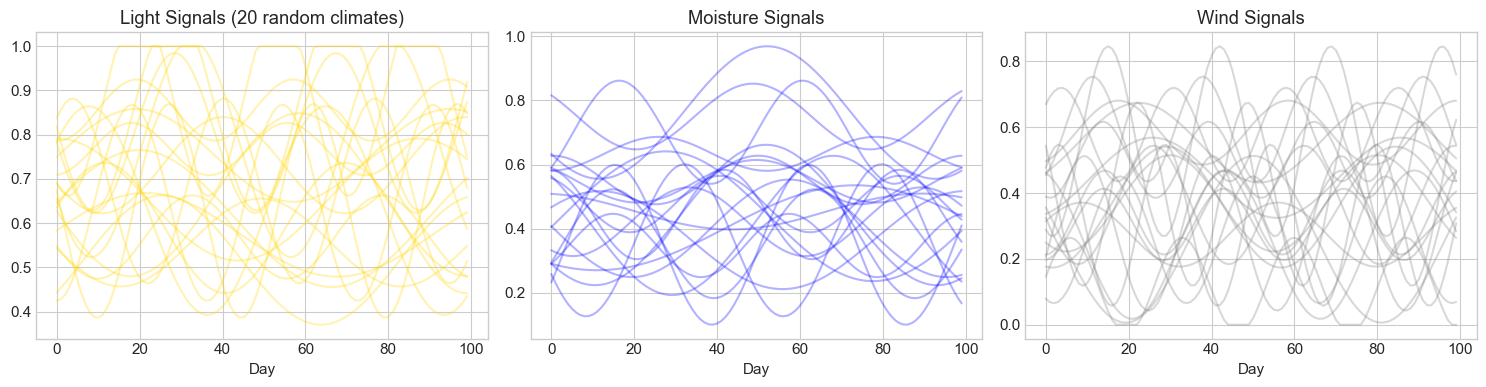

In [5]:
# Visualize climate diversity
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sample 20 climates to plot
sample_indices = np.random.choice(NUM_CLIMATES, 20, replace=False)
days = np.arange(config.num_days)

for idx in sample_indices:
    light, moisture, wind = environments[idx]
    alpha = 0.3
    axes[0].plot(days, light, alpha=alpha, color='gold')
    axes[1].plot(days, moisture, alpha=alpha, color='blue')
    axes[2].plot(days, wind, alpha=alpha, color='gray')

axes[0].set_title('Light Signals (20 random climates)')
axes[0].set_xlabel('Day')
axes[1].set_title('Moisture Signals')
axes[1].set_xlabel('Day')
axes[2].set_title('Wind Signals')
axes[2].set_xlabel('Day')

plt.tight_layout()
plt.show()

## 3. Baseline Performance

We now compare against TWO baselines:
1. **Naive baseline**: Original phased policy (doesn't know about maturity gate)
2. **Smart baseline**: Maturity-aware, resource-aware, wind-adaptive policy

The smart baseline is the FAIR comparison - if neural can't beat this, it's not learning anything useful.

In [6]:
def rollout_baseline_fruit(
    config: SimConfig,
    light_arr: Array,
    moisture_arr: Array,
    wind_arr: Array,
    policy_fn=baseline_policy,  # Can swap in smart_baseline_policy
) -> tuple[TreeState, Array, Array]:
    """
    Rollout with baseline policy and fruit-based seeds.
    
    NOTE: Uses Python loop (not fori_loop) because baseline_policy
    uses float() which breaks JAX tracing.
    """
    num_days = config.num_days
    state = TreeState.initial(energy=config.seed_energy)
    fruit_integral = 0.0
    
    for day in range(num_days):
        light = float(light_arr[day])
        moisture = float(moisture_arr[day])
        wind = float(wind_arr[day])
        
        # Accumulate fruit-days
        fruit_integral += float(state.fruit)
        
        # Get allocation from policy
        allocation = policy_fn(state, day, num_days, wind)
        
        # Step dynamics
        state = step(state, allocation, light, moisture, wind, config, day)
    
    # Seeds from fruit integral
    seeds = compute_seeds_from_fruit(jnp.array(fruit_integral), state.energy, config)
    
    return state, seeds, jnp.array(fruit_integral)


# Evaluate BOTH baselines on all climates
print("Evaluating NAIVE baseline (original phased policy)...")
naive_seeds = []
naive_fruit_integrals = []
for env in tqdm(environments, desc="Naive baseline"):
    state, seeds, fruit_integral = rollout_baseline_fruit(config, *env, policy_fn=baseline_policy)
    naive_seeds.append(float(seeds))
    naive_fruit_integrals.append(float(fruit_integral))

print("\nEvaluating SMART baseline (maturity-aware, resource-aware)...")
smart_seeds = []
smart_fruit_integrals = []
for env in tqdm(environments, desc="Smart baseline"):
    state, seeds, fruit_integral = rollout_baseline_fruit(config, *env, policy_fn=smart_baseline_policy)
    smart_seeds.append(float(seeds))
    smart_fruit_integrals.append(float(fruit_integral))

naive_seeds = np.array(naive_seeds)
smart_seeds = np.array(smart_seeds)

naive_train = naive_seeds[:n_train]
naive_test = naive_seeds[n_train:]
smart_train = smart_seeds[:n_train]
smart_test = smart_seeds[n_train:]

print(f"\nBaseline Performance Comparison:")
print(f"{'Policy':<20} {'Train Mean':<15} {'Test Mean':<15} {'Fruit Integral':<15}")
print("-" * 65)
print(f"{'Naive':<20} {naive_train.mean():<15.3f} {naive_test.mean():<15.3f} {np.mean(naive_fruit_integrals):<15.2f}")
print(f"{'Smart':<20} {smart_train.mean():<15.3f} {smart_test.mean():<15.3f} {np.mean(smart_fruit_integrals):<15.2f}")
print("-" * 65)
improvement = (smart_test.mean() - naive_test.mean()) / max(naive_test.mean(), 0.001) * 100
print(f"Smart vs Naive: {improvement:+.1f}%")

Evaluating NAIVE baseline (original phased policy)...


Naive baseline:   0%|          | 0/200 [00:00<?, ?it/s]


Evaluating SMART baseline (maturity-aware, resource-aware)...


Smart baseline:   0%|          | 0/200 [00:00<?, ?it/s]


Baseline Performance Comparison:
Policy               Train Mean      Test Mean       Fruit Integral 
-----------------------------------------------------------------
Naive                0.074           0.085           5.26           
Smart                0.036           0.050           2.47           
-----------------------------------------------------------------
Smart vs Naive: -41.2%


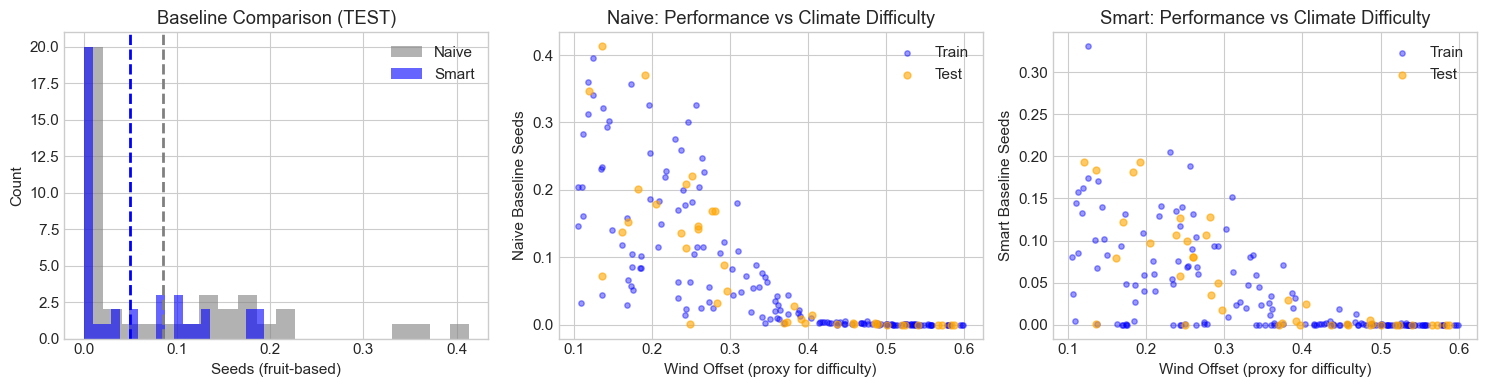

In [7]:
# Histogram of baseline performance - comparing naive vs smart
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Naive vs Smart comparison
ax = axes[0]
ax.hist(naive_test, bins=20, alpha=0.6, label='Naive', color='gray')
ax.hist(smart_test, bins=20, alpha=0.6, label='Smart', color='blue')
ax.axvline(naive_test.mean(), color='gray', linestyle='--', linewidth=2)
ax.axvline(smart_test.mean(), color='blue', linestyle='--', linewidth=2)
ax.set_xlabel('Seeds (fruit-based)')
ax.set_ylabel('Count')
ax.set_title('Baseline Comparison (TEST)')
ax.legend()

# Scatter: seeds vs wind difficulty (naive)
ax = axes[1]
wind_offsets = [c.wind.offset for c in climates]
ax.scatter(wind_offsets[:n_train], naive_train, alpha=0.4, s=15, label='Train', color='blue')
ax.scatter(wind_offsets[n_train:], naive_test, alpha=0.6, s=25, label='Test', color='orange')
ax.set_xlabel('Wind Offset (proxy for difficulty)')
ax.set_ylabel('Naive Baseline Seeds')
ax.set_title('Naive: Performance vs Climate Difficulty')
ax.legend()

# Scatter: seeds vs wind difficulty (smart)
ax = axes[2]
ax.scatter(wind_offsets[:n_train], smart_train, alpha=0.4, s=15, label='Train', color='blue')
ax.scatter(wind_offsets[n_train:], smart_test, alpha=0.6, s=25, label='Test', color='orange')
ax.set_xlabel('Wind Offset (proxy for difficulty)')
ax.set_ylabel('Smart Baseline Seeds')
ax.set_title('Smart: Performance vs Climate Difficulty')
ax.legend()

plt.tight_layout()
plt.show()

## 4. Training with Fruit-Based Seeds

In [8]:
def loss_fn_fruit(
    policy: NeuralPolicy,
    config: SimConfig,
    light_arr: Array,
    moisture_arr: Array,
    wind_arr: Array,
) -> Array:
    """Loss = negative seeds (fruit-based)."""
    _, seeds, _ = rollout_with_fruit(policy, config, light_arr, moisture_arr, wind_arr)
    return -seeds


def batch_loss(
    policy: NeuralPolicy,
    config: SimConfig,
    batch_envs: list[tuple[Array, Array, Array]],
    l2_weight: float = 0.0001,
) -> Array:
    """Average loss over a batch of climates."""
    total = 0.0
    for light, moisture, wind in batch_envs:
        total = total + loss_fn_fruit(policy, config, light, moisture, wind)
    
    # L2 regularization
    params = eqx.filter(policy, eqx.is_array)
    l2 = sum(jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params))
    
    return total / len(batch_envs) + l2_weight * l2


@eqx.filter_jit
def train_step_batch(
    policy: NeuralPolicy,
    opt_state,
    optimizer,
    config: SimConfig,
    batch_envs: list[tuple[Array, Array, Array]],
):
    """Training step with batched climates."""
    loss, grads = eqx.filter_value_and_grad(batch_loss)(policy, config, batch_envs)
    
    # Gradient clipping for stability
    grads = jax.tree_util.tree_map(
        lambda g: jnp.clip(g, -1.0, 1.0), grads
    )
    
    updates, opt_state = optimizer.update(grads, opt_state, policy)
    policy = eqx.apply_updates(policy, updates)
    return policy, opt_state, loss


print("Training functions defined (fruit-based).")

Training functions defined (fruit-based).


In [9]:
def train_on_climates(
    policy: NeuralPolicy,
    config: SimConfig,
    train_envs: list[tuple[Array, Array, Array]],
    num_epochs: int = 50,
    batch_size: int = 16,
    learning_rate: float = 0.005,
) -> tuple[NeuralPolicy, list[float]]:
    """
    Train policy on multiple climates with mini-batching.
    """
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=learning_rate * 0.1,
        peak_value=learning_rate,
        warmup_steps=10,
        decay_steps=num_epochs * (len(train_envs) // batch_size + 1),
        end_value=learning_rate * 0.01,
    )
    optimizer = optax.adam(schedule)
    opt_state = optimizer.init(eqx.filter(policy, eqx.is_array))
    
    loss_history = []
    
    for epoch in tqdm(range(num_epochs), desc="Training epochs"):
        # Shuffle training environments
        perm = np.random.permutation(len(train_envs))
        shuffled = [train_envs[i] for i in perm]
        
        epoch_losses = []
        for i in range(0, len(shuffled), batch_size):
            batch = shuffled[i:i+batch_size]
            if len(batch) < 2:  # Skip tiny batches
                continue
            
            policy, opt_state, loss = train_step_batch(
                policy, opt_state, optimizer, config, batch
            )
            epoch_losses.append(float(loss))
        
        avg_loss = np.mean(epoch_losses)
        loss_history.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}: avg_loss={avg_loss:.4f}")
    
    return policy, loss_history


# Train!
print("="*60)
print("Training neural policy with FRUIT-BASED seeds")
print("(maturity gate + stress damage)")
print("="*60)

key = jr.PRNGKey(42)
policy = NeuralPolicy(key, hidden_size=32, num_hidden=2)

policy, loss_history = train_on_climates(
    policy, config, train_envs,
    num_epochs=80,
    batch_size=16,
    learning_rate=0.005,
)

print(f"\nFinal training loss: {loss_history[-1]:.4f}")

Training neural policy with FRUIT-BASED seeds
(maturity gate + stress damage)


Training epochs:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch   0: avg_loss=-0.1094
Epoch  10: avg_loss=-0.2952
Epoch  20: avg_loss=-0.3214
Epoch  30: avg_loss=-0.3459
Epoch  40: avg_loss=-0.3592
Epoch  50: avg_loss=-0.3665
Epoch  60: avg_loss=-0.3723
Epoch  70: avg_loss=-0.3740

Final training loss: -0.3753


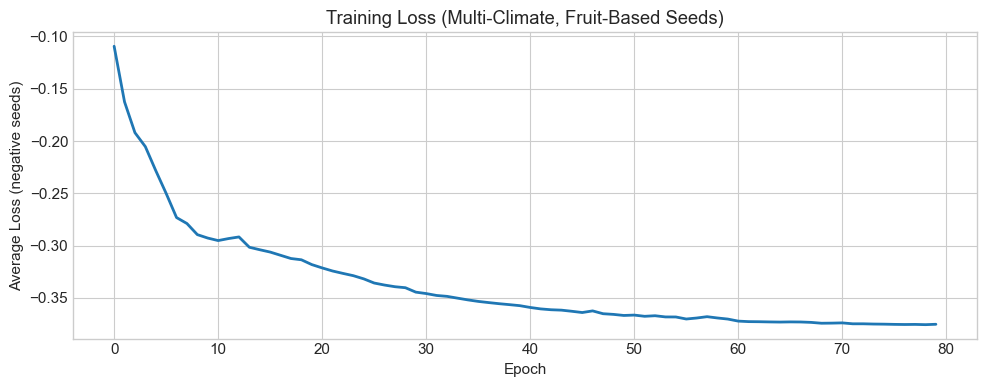

In [10]:
# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Average Loss (negative seeds)')
plt.title('Training Loss (Multi-Climate, Fruit-Based Seeds)')
plt.tight_layout()
plt.show()

## 5. Held-Out Evaluation

In [11]:
# Evaluate trained policy on all climates
jit_neural = jax.jit(partial(rollout_with_fruit, policy, config))

neural_seeds = []
neural_fruit_integrals = []
for env in tqdm(environments, desc="Neural evaluation"):
    _, seeds, fruit_integral = jit_neural(*env)
    neural_seeds.append(float(seeds))
    neural_fruit_integrals.append(float(fruit_integral))

neural_seeds = np.array(neural_seeds)
neural_train = neural_seeds[:n_train]
neural_test = neural_seeds[n_train:]

print(f"\nNeural policy performance (fruit-based seeds):")
print(f"  Train climates: mean={neural_train.mean():.3f}, std={neural_train.std():.3f}")
print(f"  Test climates:  mean={neural_test.mean():.3f}, std={neural_test.std():.3f}")
print(f"  Mean fruit integral: {np.mean(neural_fruit_integrals):.2f} fruit-days")

Neural evaluation:   0%|          | 0/200 [00:00<?, ?it/s]


Neural policy performance (fruit-based seeds):
  Train climates: mean=0.387, std=0.353
  Test climates:  mean=0.432, std=0.388
  Mean fruit integral: 18.52 fruit-days


In [12]:
# THE KEY COMPARISON: Neural vs SMART baseline (the fair test)
print("="*70)
print("HELD-OUT CLIMATE EVALUATION (DE-EXTREMIZED DYNAMICS)")
print("="*70)
print(f"{'Metric':<25} {'Naive':>12} {'Smart':>12} {'Neural':>12} {'vs Smart':>12}")
print("-"*70)

# Training set
print(f"{'Train Mean Seeds':<25} {naive_train.mean():>12.3f} {smart_train.mean():>12.3f} {neural_train.mean():>12.3f} {(neural_train.mean()/smart_train.mean()-1)*100:>+11.1f}%")

# TEST SET - THE REAL TEST
print(f"{'TEST Mean Seeds':<25} {naive_test.mean():>12.3f} {smart_test.mean():>12.3f} {neural_test.mean():>12.3f} {(neural_test.mean()/smart_test.mean()-1)*100:>+11.1f}%")

print("-"*70)

# Win rates against SMART baseline (the fair comparison)
test_wins_vs_smart = np.sum(neural_test > smart_test)
test_wins_vs_naive = np.sum(neural_test > naive_test)
print(f"{'TEST Win Rate vs Naive':<25} {'-':>12} {'-':>12} {'-':>12} {test_wins_vs_naive}/{len(neural_test)} ({test_wins_vs_naive/len(neural_test)*100:.1f}%)")
print(f"{'TEST Win Rate vs SMART':<25} {'-':>12} {'-':>12} {'-':>12} {test_wins_vs_smart}/{len(neural_test)} ({test_wins_vs_smart/len(neural_test)*100:.1f}%)")

print("="*70)

if test_wins_vs_smart > len(neural_test) * 0.5:
    print("\n✓ SUCCESS: Neural beats SMART baseline - learning real strategies!")
elif test_wins_vs_naive > len(neural_test) * 0.8:
    print("\n⚠ PARTIAL: Neural beats naive baseline but not smart baseline")
else:
    print("\n✗ FAIL: Neural not beating baselines consistently")

HELD-OUT CLIMATE EVALUATION (DE-EXTREMIZED DYNAMICS)
Metric                           Naive        Smart       Neural     vs Smart
----------------------------------------------------------------------
Train Mean Seeds                 0.074        0.036        0.387      +970.8%
TEST Mean Seeds                  0.085        0.050        0.432      +760.1%
----------------------------------------------------------------------
TEST Win Rate vs Naive               -            -            - 40/40 (100.0%)
TEST Win Rate vs SMART               -            -            - 40/40 (100.0%)

✓ SUCCESS: Neural beats SMART baseline - learning real strategies!


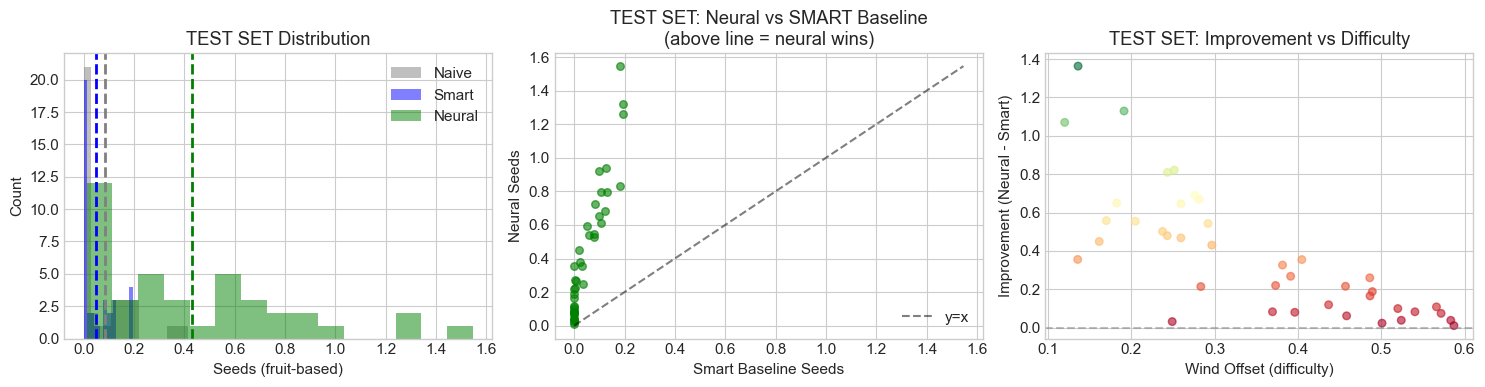

In [13]:
# Visualization: Neural vs BOTH baselines on held-out test set
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram comparison (all three)
ax = axes[0]
ax.hist(naive_test, bins=15, alpha=0.5, label='Naive', color='gray')
ax.hist(smart_test, bins=15, alpha=0.5, label='Smart', color='blue')
ax.hist(neural_test, bins=15, alpha=0.5, label='Neural', color='green')
ax.axvline(naive_test.mean(), color='gray', linestyle='--', linewidth=2)
ax.axvline(smart_test.mean(), color='blue', linestyle='--', linewidth=2)
ax.axvline(neural_test.mean(), color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Seeds (fruit-based)')
ax.set_ylabel('Count')
ax.set_title('TEST SET Distribution')
ax.legend()

# Scatter: Neural vs Smart baseline (the fair comparison)
ax = axes[1]
ax.scatter(smart_test, neural_test, alpha=0.6, s=30, c='green')
max_val = max(smart_test.max(), neural_test.max(), 0.1)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='y=x')
ax.set_xlabel('Smart Baseline Seeds')
ax.set_ylabel('Neural Seeds')
ax.set_title('TEST SET: Neural vs SMART Baseline\n(above line = neural wins)')
ax.legend()

# Improvement vs difficulty (against smart baseline)
ax = axes[2]
test_wind_offsets = [climates[i].wind.offset for i in range(n_train, NUM_CLIMATES)]
improvement = neural_test - smart_test
scatter = ax.scatter(test_wind_offsets, improvement, alpha=0.6, s=30, c=improvement, cmap='RdYlGn')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Wind Offset (difficulty)')
ax.set_ylabel('Improvement (Neural - Smart)')
ax.set_title('TEST SET: Improvement vs Difficulty')

plt.tight_layout()
plt.show()

## 6. Policy Behavior Analysis

Key questions:
1. Does flowering begin after maturity threshold (not day 0)?
2. Does fruit accumulate mid-to-late season (not immediately)?
3. Does the policy adapt to stress (reduce flowering under wind/drought)?

/var/folders/_0/j0_zkq_d3jn0klz033gq33cc0000gn/T/ipykernel_28069/2446330405.py:92: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nathan/Projects/ndouglas/arborhedron/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


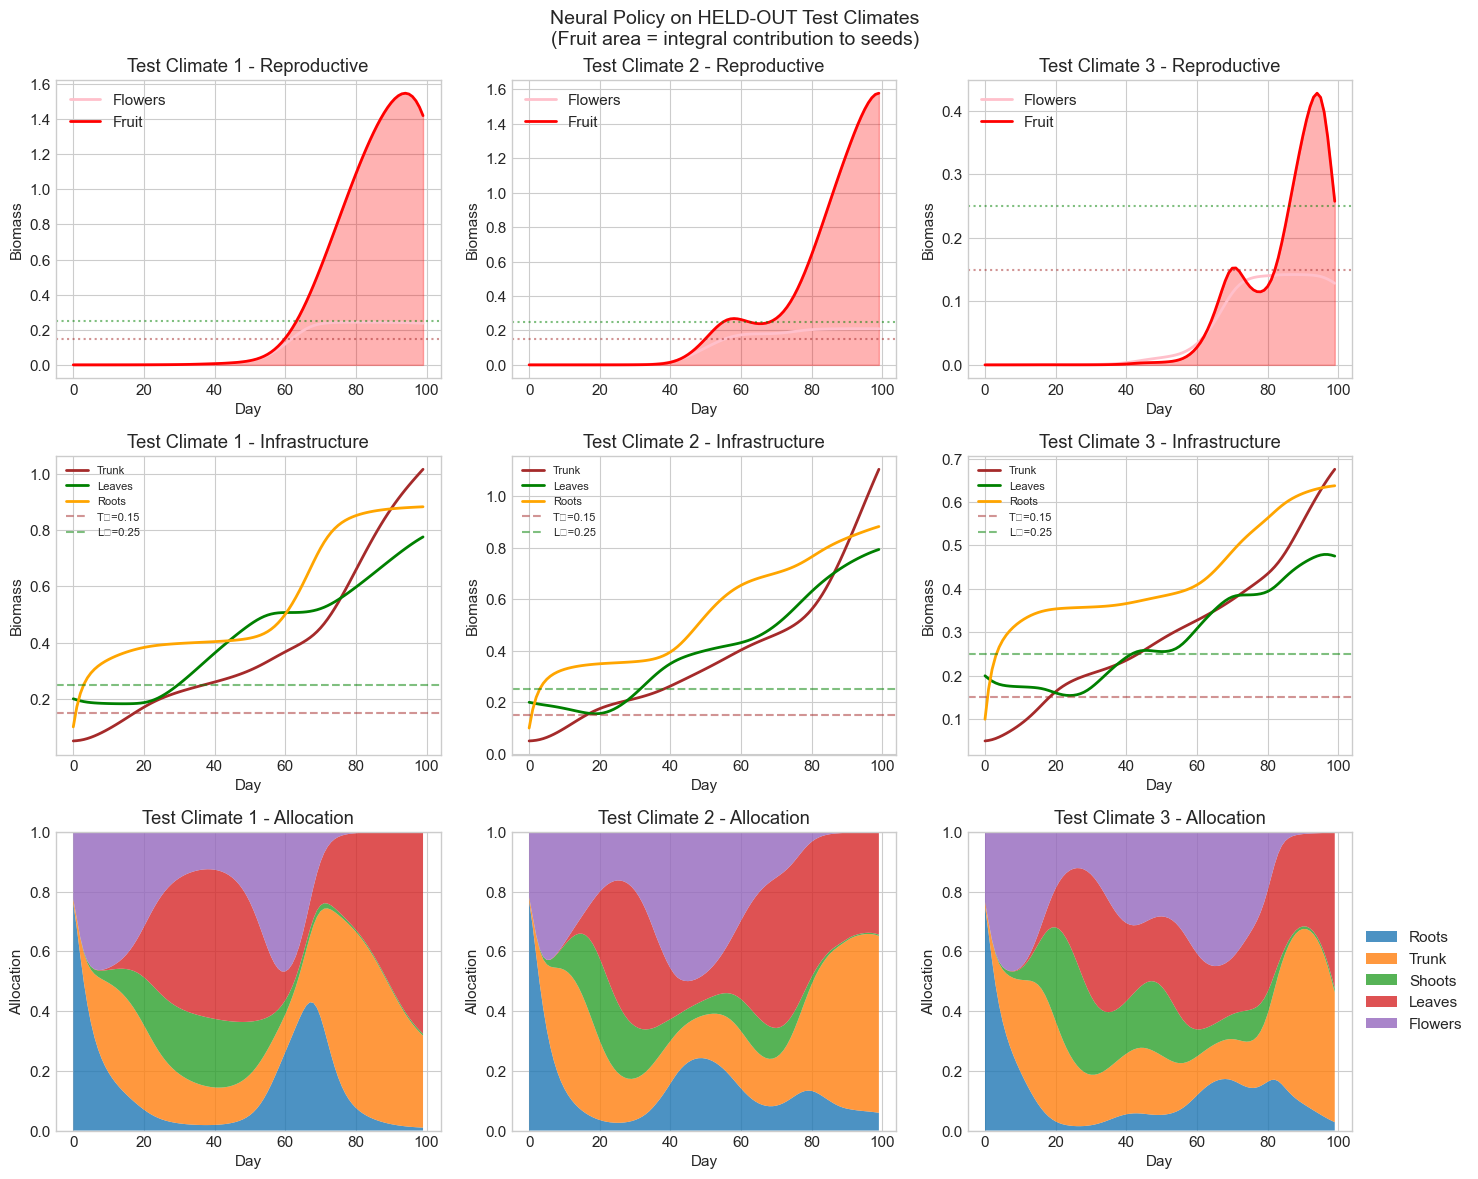

In [14]:
def analyze_policy_fruit(policy, config, light_arr, moisture_arr, wind_arr):
    """Run policy and collect trajectory data including fruit."""
    state = TreeState.initial(energy=config.seed_energy)
    
    history = {
        'flowers': [], 'fruit': [], 'trunk': [], 'leaves': [], 'roots': [],
        'energy': [], 'water': [],
    }
    allocs_hist = {k: [] for k in ['roots', 'trunk', 'shoots', 'leaves', 'flowers']}
    
    for day in range(config.num_days):
        light = float(light_arr[day])
        moisture = float(moisture_arr[day])
        wind = float(wind_arr[day])
        
        # Record state
        history['flowers'].append(float(state.flowers))
        history['fruit'].append(float(state.fruit))
        history['trunk'].append(float(state.trunk))
        history['leaves'].append(float(state.leaves))
        history['roots'].append(float(state.roots))
        history['energy'].append(float(state.energy))
        history['water'].append(float(state.water))
        
        # Get allocation
        features = make_policy_features(state, day, config.num_days, light, moisture, wind)
        logits = policy(features)
        alloc = softmax_allocation(logits)
        
        allocs_hist['roots'].append(float(alloc.roots))
        allocs_hist['trunk'].append(float(alloc.trunk))
        allocs_hist['shoots'].append(float(alloc.shoots))
        allocs_hist['leaves'].append(float(alloc.leaves))
        allocs_hist['flowers'].append(float(alloc.flowers))
        
        # Step
        state = step(state, alloc, light, moisture, wind, config, day)
    
    return history, allocs_hist


# Analyze on a few test climates
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

test_indices = [n_train, n_train + 10, n_train + 20]  # 3 test climates
days = np.arange(config.num_days)

for col, idx in enumerate(test_indices):
    history, allocs = analyze_policy_fruit(policy, config, *environments[idx])
    
    # Row 1: Flowers and Fruit trajectory
    ax = axes[0, col]
    ax.plot(days, history['flowers'], linewidth=2, color='pink', label='Flowers')
    ax.plot(days, history['fruit'], linewidth=2, color='red', label='Fruit')
    ax.fill_between(days, 0, history['fruit'], alpha=0.3, color='red')
    ax.set_xlabel('Day')
    ax.set_ylabel('Biomass')
    ax.set_title(f'Test Climate {col+1} - Reproductive')
    ax.legend()
    
    # Mark maturity thresholds
    ax.axhline(config.fruit_maturity_trunk, color='brown', linestyle=':', alpha=0.5)
    ax.axhline(config.fruit_maturity_leaves, color='green', linestyle=':', alpha=0.5)
    
    # Row 2: Infrastructure (trunk, leaves, roots)
    ax = axes[1, col]
    ax.plot(days, history['trunk'], linewidth=2, color='brown', label='Trunk')
    ax.plot(days, history['leaves'], linewidth=2, color='green', label='Leaves')
    ax.plot(days, history['roots'], linewidth=2, color='orange', label='Roots')
    ax.axhline(config.fruit_maturity_trunk, color='brown', linestyle='--', alpha=0.5, label=f'T₀={config.fruit_maturity_trunk}')
    ax.axhline(config.fruit_maturity_leaves, color='green', linestyle='--', alpha=0.5, label=f'L₀={config.fruit_maturity_leaves}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Biomass')
    ax.set_title(f'Test Climate {col+1} - Infrastructure')
    ax.legend(fontsize=8)
    
    # Row 3: Allocation strategy
    ax = axes[2, col]
    ax.stackplot(days,
        allocs['roots'], allocs['trunk'], allocs['shoots'],
        allocs['leaves'], allocs['flowers'],
        labels=['Roots', 'Trunk', 'Shoots', 'Leaves', 'Flowers'],
        alpha=0.8)
    ax.set_xlabel('Day')
    ax.set_ylabel('Allocation')
    ax.set_title(f'Test Climate {col+1} - Allocation')
    ax.set_ylim(0, 1)
    if col == 2:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Neural Policy on HELD-OUT Test Climates\n(Fruit area = integral contribution to seeds)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Sanity Check: When Does Fruit Accumulate?

If the maturity gate works, fruit should NOT accumulate on day 0.
It should start appearing after trunk/leaves/roots exceed thresholds.

Fruit timing on TEST climates:
  Mean first fruit day: 50.2
  Min first fruit day: 37
  Max first fruit day: 80
  Climates with no fruit: 0


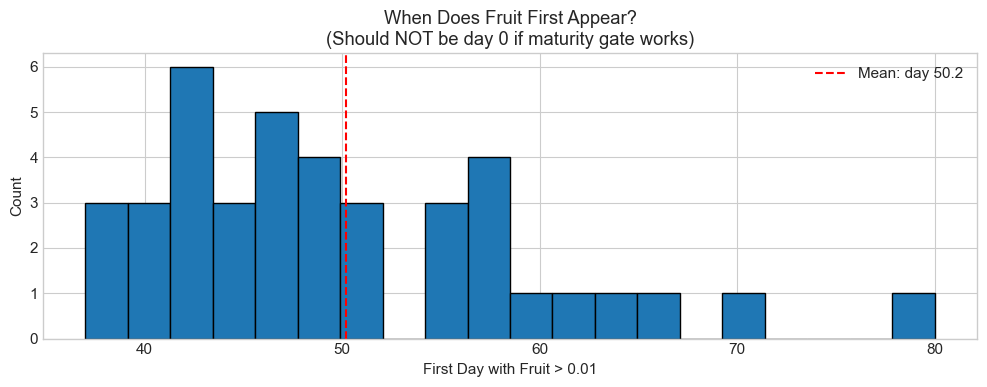


✓ MATURITY GATE WORKING: No immediate fruiting!


In [15]:
# Check when fruit first appears across all test climates
first_fruit_days = []

for idx in range(n_train, NUM_CLIMATES):
    history, _ = analyze_policy_fruit(policy, config, *environments[idx])
    
    # Find first day with fruit > 0.01
    for day, fruit in enumerate(history['fruit']):
        if fruit > 0.01:
            first_fruit_days.append(day)
            break
    else:
        first_fruit_days.append(config.num_days)  # Never fruited

first_fruit_days = np.array(first_fruit_days)

print("Fruit timing on TEST climates:")
print(f"  Mean first fruit day: {first_fruit_days.mean():.1f}")
print(f"  Min first fruit day: {first_fruit_days.min()}")
print(f"  Max first fruit day: {first_fruit_days.max()}")
print(f"  Climates with no fruit: {np.sum(first_fruit_days >= config.num_days)}")

plt.figure(figsize=(10, 4))
plt.hist(first_fruit_days, bins=20, edgecolor='black')
plt.axvline(first_fruit_days.mean(), color='red', linestyle='--', label=f'Mean: day {first_fruit_days.mean():.1f}')
plt.xlabel('First Day with Fruit > 0.01')
plt.ylabel('Count')
plt.title('When Does Fruit First Appear?\n(Should NOT be day 0 if maturity gate works)')
plt.legend()
plt.tight_layout()
plt.show()

if first_fruit_days.min() > 5:
    print("\n✓ MATURITY GATE WORKING: No immediate fruiting!")
else:
    print("\n⚠ WARNING: Fruit appearing very early - check maturity gate.")

## 8. Summary

In [16]:
print("="*70)
print("DE-EXTREMIZED EVALUATION SUMMARY")
print("="*70)

print(f"""
1. ANTI-EXPLOIT MECHANISMS
   - Maturity gate: m(t) = σ(k(T-{config.fruit_maturity_trunk})) · σ(k(L-{config.fruit_maturity_leaves})) · σ(k(R-{config.fruit_maturity_roots}))
   - Saturating conversion: F/(F+{config.fruit_saturation_k})
   - Resource gates: leaves, water, light must be sufficient
   - Flower maintenance: {config.m_flower} (2x higher)
   - Stress damage: wind={config.fruit_wind_vulnerability}, drought={config.fruit_drought_vulnerability}

2. HELD-OUT CLIMATE EVALUATION
   - Trained on {n_train} random climates
   - Tested on {NUM_CLIMATES - n_train} held-out climates
   - Naive baseline mean: {naive_test.mean():.3f}
   - Smart baseline mean: {smart_test.mean():.3f}
   - Neural mean: {neural_test.mean():.3f}
   - Win rate vs SMART: {test_wins_vs_smart}/{len(neural_test)} ({test_wins_vs_smart/len(neural_test)*100:.1f}%)

3. TIMING ANALYSIS
   - Mean first fruit day: {first_fruit_days.mean():.1f}
   - Earliest fruit day: {first_fruit_days.min()}
""")

if first_fruit_days.min() > 5 and test_wins_vs_smart > len(neural_test) * 0.5:
    print("   ✓ SUCCESS: Maturity gate + de-extremization working!")
    print("   ✓ Neural beats smart baseline - learning real strategies!")
elif first_fruit_days.min() > 5 and test_wins_vs_naive > len(neural_test) * 0.8:
    print("   ✓ PARTIAL SUCCESS: Maturity gate working")
    print("   ⚠ Neural beats naive but not smart baseline - may need more training")
else:
    print("   ⚠ Check allocation plots for 'all-purple' camping behavior")

print("="*70)

DE-EXTREMIZED EVALUATION SUMMARY

1. ANTI-EXPLOIT MECHANISMS
   - Maturity gate: m(t) = σ(k(T-0.15)) · σ(k(L-0.25)) · σ(k(R-0.15))
   - Saturating conversion: F/(F+0.3)
   - Resource gates: leaves, water, light must be sufficient
   - Flower maintenance: 0.08 (2x higher)
   - Stress damage: wind=0.4, drought=0.3

2. HELD-OUT CLIMATE EVALUATION
   - Trained on 160 random climates
   - Tested on 40 held-out climates
   - Naive baseline mean: 0.085
   - Smart baseline mean: 0.050
   - Neural mean: 0.432
   - Win rate vs SMART: 40/40 (100.0%)

3. TIMING ANALYSIS
   - Mean first fruit day: 50.2
   - Earliest fruit day: 37

   ✓ SUCCESS: Maturity gate + de-extremization working!
   ✓ Neural beats smart baseline - learning real strategies!
